In [1]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Statistics
using ProgressBars   
using DSP
using Symbolics
using Trapz
using SymPy
using NBInclude
@nbinclude("Graphing_code.ipynb")
@nbinclude("Enrichment_functions.ipynb")
@nbinclude("Mapping_functions.ipynb")
@nbinclude("Measurement functions and others.ipynb")

measure_correlation_matrix (generic function with 1 method)

In [13]:

J = "boxcar"                                 #choice of bath spectral function
N = 12                                       # Number of sites
Ns = 3                                       #Number of system sites (not including ancilla)                                               
Krylov_cutoff = 1E-5                         # site list
β = 0;                                       #inverse temperature
D = 10                                       #half bandwidth
Γ = 0.1                                      # total impurity-bath strength
k1 = 5
k2 = 3                                       # Number of Krylov states
τ_Krylov = 1





Nb = Int((N-2*Ns)/2)                          #Number of bath sites (not including ancilla) 
s = siteinds("Fermion", N)                    # Array of site indices  
sites = 1:N                                   # site list
ϵi = 0.5*ones(Ns); 
t = sqrt(Γ/(pi * Nb)) 


"""
This is where the code with differ if we use the recursive mapping. The V_k and ϵb will be different. 
"""
V_k, ϵb = spectral_density(J,Nb,Γ,D,ϵi)                 
f_k = 1 ./(1 .+exp.(β*ϵb))                    # Fermi distributions of the bath modes

c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cd = ops(s, [("Cdag", n) for n in sites]);    # creation operators
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identiy operators
end;


###Constructs Initial state
vac = productMPS(s, "0");

print("bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3")

choice = parse(Int,readline())
ψ = initialise_psi(choice,f_k,Ns)
  
for i =1:length(linkdims(ψ))
    """
    Don't understand why this function isn't working. The tags created by the gates are not correct. 
    """
    replacetags(linkind(ψ,i),tags(linkind(ψ,i)),tags(linkind(vac,i)))
end


#The following code is not optimised, various objects are created multiple times
#and within each different option there is identical code which doesn't
#need to be written multiple times.

H = H(N,Ns,ϵi,V_k,ϵb,choice,s)

println("here1")
k1 = 10
Krylov = Krylov_states(H,ψ,k1,τ_Krylov,s);
println("here2")

ψ[N]= ψ[N]/norm(ψ)
println("here3")
ψ1 = enrich_generic3(ψ, Krylov; Krylov_cutoff);
println("1 - overlap of initial state and enriched initial state = ",1-inner(ψ,ψ1))
ψ = ψ1
Ci = transpose(correlation_matrix(ψ,"Cdag","C"));
println("here4")

###Initial Entropy
SvN_init = entanglement_entropy(ψ);


###density of initial state
num_init = expect(ψ,"n");

###Initial state
ψ_init = deepcopy(ψ);

  

stdin> 3
bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3here1
here2
here3
1 - overlap of initial state and enriched initial state = 0.0 + 1.9259299443872363e-34im
here4


In [83]:

tdvp_cutoff = 1e-30 ##TRY ZERO
Krylov_cutoff = 1e-5
δt1 = 1e-3                                   # Time-step
δt2 = 1e-2
δt = 1e-2
T = 0.1                                     # Total time
T_enrich = 2e-2                               # Time when the state is enriched in each step
T_unenriched = T-T_enrich                    # Time when the state is no longer enriched each step                                             # Number of time steps
nframe_en1 = Int(ceil(T_enrich/δt1))
nframe_en = Int(ceil(T_enrich/δt))
nframe_un =  Int(ceil(T_unenriched/δt2))

k2=3
ψe = deepcopy(ψ)
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN)

for i in ProgressBar(1:(nframe_en))
    
    ψe = tdvp(H,-im * δt,ψe; time_step = -im * δt1, cutoff = tdvp_cutoff, 
        outputlevel=1, normalize=false, (observer!)=obs)
    
    Krylov_i = Krylov_states(H,ψe,k2,τ_Krylov,s);
  #  @assert(minimum(Krylov_linkdims(Krylov) .- length(Krylov)) ==0)
    ψe2 = enrich_generic3(ψe, Krylov_i; Krylov_cutoff)
    @assert abs(1-inner(ψe2,ψe)) <1e-10
  
    ψe = ψe2
    
end

@time ψf = tdvp(H,-im * T_unenriched,ψe; time_step = -im * δt2, cutoff = tdvp_cutoff, outputlevel=1, normalize=false, (observer!)=obs)

res = results(obs)
times = res["times"]
corr = res["corr"]
SvN = res["SvN"];


###exact propagation
### Correlation functions evolve as U'*Ci*U, not the other way around.
U= exp(-im*T*H_single);
Cf_test = U*Ci*U';
#Cf = transpose(correlation_matrix(ψf,"Cdag","C"));

     

0.0%┣                                                ┫ 0/2 [00:00<00:00, -0s/it]

After sweep 1: maxlinkdim=8 maxerr=4.62E-31 current_time=0.0 - 0.001im time=0.128


After sweep 2: maxlinkdim=8 maxerr=1.18E-31 current_time=0.0 - 0.002im time=0.101
After sweep 3: maxlinkdim=8 maxerr=4.72E-31 current_time=0.0 - 0.003im time=0.101
After sweep 4: maxlinkdim=9 maxerr=6.77E-31 current_time=0.0 - 0.004im time=0.108
After sweep 5: maxlinkdim=9 maxerr=8.92E-31 current_time=0.0 - 0.005im time=0.167
After sweep 6: maxlinkdim=9 maxerr=8.08E-31 current_time=0.0 - 0.006im time=0.094
After sweep 7: maxlinkdim=9 maxerr=6.43E-31 current_time=0.0 - 0.007im time=0.112
After sweep 8: maxlinkdim=9 maxerr=6.12E-31 current_time=0.0 - 0.008im time=0.108
After sweep 9: maxlinkdim=9 maxerr=3.59E-31 current_time=0.0 - 0.009im time=0.104
After sweep 10: maxlinkdim=9 maxerr=5.04E-31 current_time=0.0 - 0.01im time=0.105


50.0%┣█████████████████████▌                     ┫ 1/2 [00:01<Inf:Inf, InfGs/it]


After sweep 1: maxlinkdim=10 maxerr=8.91E-31 current_time=0.0 - 0.001im time=0.115
After sweep 2: maxlinkdim=11 maxerr=1.71E-31 current_time=0.0 - 0.002im time=0.163
After sweep 3: maxlinkdim=11 maxerr=3.40E-31 current_time=0.0 - 0.003im time=0.108
After sweep 4: maxlinkdim=11 maxerr=1.65E-31 current_time=0.0 - 0.004im time=0.109
After sweep 5: maxlinkdim=11 maxerr=2.16E-31 current_time=0.0 - 0.005im time=0.103
After sweep 6: maxlinkdim=11 maxerr=1.89E-31 current_time=0.0 - 0.006im time=0.094
After sweep 7: maxlinkdim=11 maxerr=1.26E-31 current_time=0.0 - 0.007im time=0.109
After sweep 8: maxlinkdim=11 maxerr=1.13E-31 current_time=0.0 - 0.008im time=0.106
After sweep 9: maxlinkdim=11 maxerr=9.78E-32 current_time=0.0 - 0.009im time=0.112
After sweep 10: maxlinkdim=11 maxerr=1.11E-31 current_time=0.0 - 0.01im time=0.096


100.0%┣███████████████████████████████████████████████┫ 2/2 [00:03<00:00, 3s/it]
100.0%┣███████████████████████████████████████████████┫ 2/2 [00:03<00:00, 3s/it]


After sweep 1: maxlinkdim=19 maxerr=9.97E-31 current_time=0.0 - 0.01im time=0.213
After sweep 2: maxlinkdim=20 maxerr=5.21E-31 current_time=0.0 - 0.02im time=0.228
After sweep 3: maxlinkdim=21 maxerr=7.95E-31 current_time=0.0 - 0.03im time=0.266
After sweep 4: maxlinkdim=21 maxerr=9.89E-31 current_time=0.0 - 0.04im time=0.196
After sweep 5: maxlinkdim=22 maxerr=6.57E-31 current_time=0.0 - 0.05im time=0.205
After sweep 6: maxlinkdim=23 maxerr=9.16E-31 current_time=0.0 - 0.06im time=0.222
After sweep 7: maxlinkdim=23 maxerr=5.62E-31 current_time=0.0 - 0.07im time=0.274
After sweep 8: maxlinkdim=23 maxerr=7.49E-31 current_time=0.0 - 0.08im time=0.211
  1.939560 seconds (736.86 k allocations: 392.782 MiB, 4.18% gc time)


time_list = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.009999999999999998, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02, 0.03, 0.04, 0.05, 0.06, 0.06999999999999999, 0.08000000000000002, 0.09, 0.1]
trace_list = Any[0, 3.131264053308887e-13, 9.342030379134763e-13, 1.560652078311692e-12, 2.200103910174475e-12, 6.4738612168614975e-12, 7.077567059335432e-12, 7.69517746108518e-12, 8.317536117129433e-12, 8.941071284104332e-12, 9.564148912851733e-12, 9.996619089597452e-12, 1.0611901398466288e-11, 1.1224043646383839e-11, 1.1834238879290236e-11, 1.2440488129959529e-11, 1.3043437575755331e-11, 1.3642563441445995e-11, 1.4234846283965954e-11, 1.4825225367871454e-11, 1.5407841394321724e-11, 0.0011675811549083834, 0.002335155172866285, 0.0035027149341651, 0.004670253327105229, 0.005837763198339577, 0.00700523742968145, 0.00817266886613083, 0.009340050452489531]


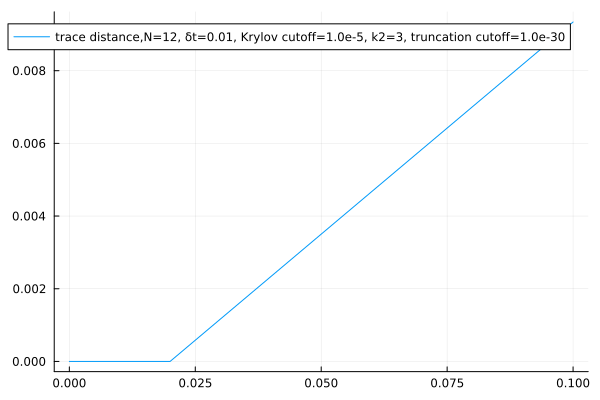

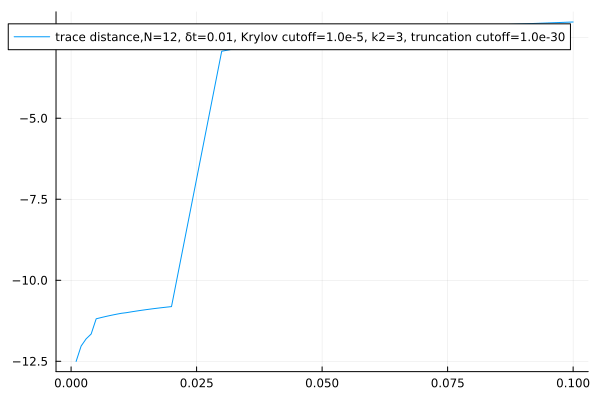

In [91]:

other_norms=false
save_bool = false
times1 = Vector(LinRange(δt1,T_enrich,Int(nframe_en1)))
times2 = Vector(LinRange(T_enrich+δt,T,Int(nframe_un)))
 
error_propagation2(corr,times1,times2,H_single,δt1,δt2,Ci,N,Krylov_cutoff,k2,tdvp_cutoff,other_norms,save_bool)


In [85]:
length(times2)

8

In [74]:
append!(times1,times2)

search: push push! pushfirst pushfirst! pushdisplay expanduser PlotUtils



```
push(is::Indices, i::Index)
```

Make a new Indices with the Index i inserted at the end.


In [61]:
Vector(LinRange(δt1,T_enrich,Int(nframe_en1)))

20-element Vector{Float64}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.009999999999999998
 0.011
 0.012
 0.013
 0.014
 0.015
 0.016
 0.017
 0.018000000000000002
 0.019
 0.02

In [59]:
length(times2)

8

In [62]:
length(times1)

29

In [110]:
function reaction_mapping(w,J,L)
   
   # J = J*(heaviside(w+1) - heaviside(w-1)); # Ensure input function is clipped to the domain.
    
    #Define fixed numerical mesh over [-2,2] to capture spectral function and
    # its hilbert transform correctly within [-1,1].
    samp = 1000 # Number of points in mesh.
    x = LinRange(-2,2,samp);
    Jx = zeros(samp)
    Jx =[J(xi) for xi in x]  # Evaluate symbolic input function over the grid.

    tsq = zeros(1,L)
    en = zeros(1,L)
    # Loop over the omega intervals and perform integrations:
    Jcur = Jx; # Current bath spectral function.
    for s=1:L
      
      # Simple trapezoid integration for hopping squared and on-site energy:
      tsq[s] = trapz(x,Jcur); 
      en[s] = (1/tsq[s])*trapz(x,x.*Jcur);

      Jprev = Jcur;
      JH = imag(hilbert(Jprev)); # Hilbert transform.
      Jcur = ((tsq[s]/pi)^2)*Jprev./(JH.^2+Jprev.^2);
    end
    
    return tsq, en
end
L = 10    
reaction_mapping(w,J,L)[2]    
    

1×10 Matrix{Float64}:
 3.07725e-16  1.66582e-18  -6.44109e-17  …  1.04843e-16  -1.71387e-16

In [46]:
@variables w; #% Define dimensionless angular frequency w symbolically.
@syms Jb[1:5]# % Define symbolic bath DOS function.


(Jb,)

In [55]:
J(w)

0.6366197723675814sqrt(1 - (w^2))

In [88]:
x = LinRange(-2,2,1000)
J(x)

LoadError: MethodError: no method matching Complex(::Vector{Float64})
[0mClosest candidates are:
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at char.jl:50
[0m  (::Type{T})([91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:266
[0m  Complex([91m::Real[39m) at complex.jl:18
[0m  ...

In [100]:

    
J(w) = (2*V^2*sqrt(Complex(1 -w^2)/pi);


1000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

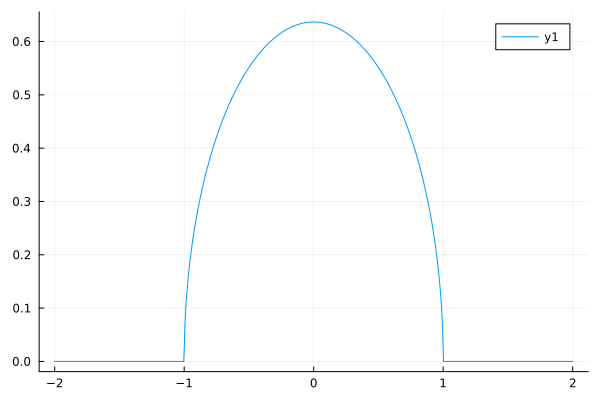

In [102]:
plot(x,Jx)

In [9]:

"""

What to do next:

-We need to work out whether the relative magnitudes of the Krylov states matter, i.e. do we include the delta t?

-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.
-I think I should have error checks for various properties of all the objects, i.e. the norm of ρ_n etc.

-Once the projector is diagonalised, the spectra are either 0 or 1, but numerically they deviate from this by an order of
~1e-14. Is there a way of recovering Vp from the diagonal matrix after the values have been rounded?

-The stochastic enrichment method is much more efficient and seems quite straight forward to implement.

-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.

-Ask on the discourse page if 1TDVP is implemented as this could be another option.



"""
     

5-element Vector{Float64}:
  1.7013016167040798
 -1.3763819204711736
 -0.6498393924658126
 -1.3763819204711734
  1.70130161670408

In [ ]:
"""
Potential efficiency improvements:

-Always sweeping towards the centre will prevent Projectors having an unnecessarily large dimension.

-At the end of the enrichment, the enriched state is almost canonical apart from the first sight which carries this 
extra k factor. Does TDVP need an orthogonal centre at N? If not, we may be able to avoid orthogonalization?

-    In most cases, abs_maxdim will be very high. We don't want to use this. However, if 
    for the other option we use the sum of all the linkdimensions (for n-1) of the Krylov states, 
    It won't be in canonical form so many of the dimensions will actually correspond to the same dimension. 
    Again, this isn't a huge problem because it will still likely be much less than abs_maxdim. I'm not sure how 
    this can be prevented, so I will just use the sum.
    
- Question: Does the kth Krylov state always contain within it the dimensions of the lower order Krylov states?
 This would solve the problem stated just about and would be more efficient.


-For 1TDVP, they found that for k=5 the creation of the Krylov states and the enrichment step were subleading to the TDVP step, but this isn't
what I have at the moment. 2TDVP is slower than 1TDVP but more accurate, so we don't know if these steps should be subleading to TDVP or not, but 
there's definitely ways of increasing the efficiency of these steps.


-There's a more efficient but less accurate way to apply H to ψ, by using the variational approach that's used in TDVP itself. 


-In the paper, they say to use τ=δt but I'm not sure about this as for small delta t, these states won't be that different (think about this more).


-The bottleneck is creating the Krylov states, see if you can make the function more efficient (Vectorise?). 

-During the enrichment, there will be sites that are aleady max rank, i.e close to the first site. Instead of SvDing through
these sights manually, we could use orthogonalize to go between sites that can be enriched. I.e. say we have just enriched
site k, and the next site that can be enriched is site k-n. Instead of SvDing the n states between these two, we could use 
orthogonalize(ψ,k-n) to move to this sight.
"""